In [4]:
import pandas as pd
import ast
import numpy as np
import json
import joblib
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge ,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [69]:
pd.set_option('display.max_columns', None)
cities=[r"/content/drive/MyDrive/Car dheko/hyderabad_cars.xlsx",
    r"/content/drive/MyDrive/Car dheko/jaipur_cars.xlsx",
    r"/content/drive/MyDrive/Car dheko/delhi_cars.xlsx",
    r"/content/drive/MyDrive/Car dheko/kolkata_cars.xlsx",
    r"/content/drive/MyDrive/Car dheko/chennai_cars.xlsx",
    r"/content/drive/MyDrive/Car dheko/bangalore_cars.xlsx"
]

city_names = ["Hyderabad", "Jaipur", "Delhi", "Chennai", "Kolkata", "Bangalore"]

# Creating an empty list to store the dataframes
dfs = []

for city, name in zip(cities, city_names):
    df = pd.read_excel(city)
    df['City'] = name  # Add the city column
    dfs.append(df)

# Combine all dataframes into a single +
data = pd.concat(dfs, ignore_index=True)
data.head(2)

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links,City
0,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...,Hyderabad
1,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/buy-used-car-details/...,Hyderabad


In [70]:
# Drop 'car_links' column
data = data.drop('car_links', axis=1)

In [7]:
data.loc[0,'new_car_detail']

"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', 'km': '20,000', 'transmission': 'Automatic', 'ownerNo': 1, 'owner': '1st Owner', 'oem': 'Volkswagen', 'model': 'Volkswagen Polo', 'modelYear': 2022, 'centralVariantId': 7746, 'variantName': '1.0 TSI Highline Plus AT', 'price': '₹ 10.44 Lakh', 'priceActual': '', 'priceSaving': '', 'priceFixedText': None, 'trendingText': {'imgUrl': 'https://stimg.cardekho.com/used-cars/common/icons/trending.svg', 'heading': 'Trending Car!', 'desc': 'High chances of sale in next 6 days'}}"

In [71]:
# Define a function to safely parse the JSON-like strings
def parse_json_like(column_data):
    try:
        return ast.literal_eval(column_data)
    except:
        return {}

# Apply the parsing function to the 'new_car_detail' column
data['parsed_car_detail'] = data['new_car_detail'].apply(parse_json_like)

# Extracting relevant fields from the parsed data
car_detail_df = pd.json_normalize(data['parsed_car_detail'])

# Display the extracted fields
print(car_detail_df)
#print(car_detail_df.head())

      it      ft         bt        km transmission  ownerNo      owner  \
0      0  Petrol  Hatchback    20,000    Automatic        1  1st Owner   
1      0  Petrol  Hatchback    85,582       Manual        2  2nd Owner   
2      0  Petrol        SUV    10,000       Manual        1  1st Owner   
3      0  Petrol  Hatchback    50,750       Manual        1  1st Owner   
4      0  Petrol        SUV    10,000    Automatic        1  1st Owner   
...   ..     ...        ...       ...          ...      ...        ...   
8364   0  Diesel        SUV  1,56,039       Manual        2  2nd Owner   
8365   0  Petrol      Sedan    56,000       Manual        2  2nd Owner   
8366   0  Petrol  Hatchback    42,000       Manual        2  2nd Owner   
8367   0  Diesel  Hatchback    93,003       Manual        1  1st Owner   
8368   0  Petrol  Hatchback    36,000    Automatic        2  2nd Owner   

             oem              model  modelYear  centralVariantId  \
0     Volkswagen    Volkswagen Polo       2

In [9]:
car_detail_df.columns

Index(['it', 'ft', 'bt', 'km', 'transmission', 'ownerNo', 'owner', 'oem',
       'model', 'modelYear', 'centralVariantId', 'variantName', 'price',
       'priceActual', 'priceSaving', 'priceFixedText', 'trendingText.imgUrl',
       'trendingText.heading', 'trendingText.desc'],
      dtype='object')

In [72]:
car_detail_df.drop(columns=[ 'it','owner','centralVariantId','priceActual','priceSaving','priceFixedText','trendingText.imgUrl','trendingText.heading','trendingText.desc'],inplace=True)

In [11]:
car_detail_df.columns

Index(['ft', 'bt', 'km', 'transmission', 'ownerNo', 'oem', 'model',
       'modelYear', 'variantName', 'price'],
      dtype='object')

In [12]:
data.loc[0,['new_car_overview']]

,0
new_car_overview,"{'heading': 'Car overview', 'top': [{'key': 'R..."


In [73]:
# Apply the parsing function to new_car_overview' column
data['parsed_car_overview'] = data['new_car_overview'].apply(parse_json_like)

# Function to extract key-value pairs from the 'top' list in each column
def extract_top_data(column_data, prefix):
    extracted_data = {}
    for item in column_data:
        key = f"{prefix}_{item.get('key', '').replace(' ', '_').lower()}"
        extracted_data[key] = item.get('value', None)
    return extracted_data

# Extracting details from 'new_car_overview'
data['overview_details'] = data['parsed_car_overview'].apply(lambda x: extract_top_data(x.get('top', []), 'overview'))

# Creating DataFrames from the extracted data
overview_details_df = pd.DataFrame(data['overview_details'].tolist())
print(overview_details_df)

     overview_registration_year overview_insurance_validity  \
0                          2022       Third Party insurance   
1                      Oct 2014       Third Party insurance   
2                          2023       Third Party insurance   
3                      Mar 2017       Third Party insurance   
4                          2022       Third Party insurance   
...                         ...                         ...   
8364                   May 2012               Comprehensive   
8365                   Jun 2008       Third Party insurance   
8366                  Sept 2014               Comprehensive   
8367                   Dec 2018               Comprehensive   
8368                   May 2017               Comprehensive   

     overview_fuel_type overview_seats overview_kms_driven overview_rto  \
0                Petrol        5 Seats          20,000 Kms         TS04   
1                Petrol        5 Seats          85,582 Kms         TS09   
2                P

In [74]:
overview_details_df.drop(columns=['overview_transmission','overview_ownership','overview_kms_driven','overview_fuel_type','overview_year_of_manufacture'],inplace=True)

In [15]:
data.loc[0,['new_car_feature']]

,0
new_car_feature,"{'heading': 'Features', 'top': [{'value': 'Pow..."


In [75]:
data['parsed_car_feature'] = data['new_car_feature'].apply(parse_json_like)

# Extracting top features
data['top_features'] = data['parsed_car_feature'].apply(lambda x: [item['value'] for item in x['top']])
# Extracting data for Comfort & Convenience
data['comfort_and_convenience'] = data['parsed_car_feature'].apply(lambda x: [item['value'] for section in x['data'] if section['heading'] == 'Comfort & Convenience' for item in section['list']])

# Extracting data for Interior
data['interior'] = data['parsed_car_feature'].apply(lambda x: [item['value'] for section in x['data'] if section['heading'] == 'Interior' for item in section['list']])

# Extracting data for Exterior
data['exterior'] = data['parsed_car_feature'].apply(lambda x: [item['value'] for section in x['data'] if section['heading'] == 'Exterior' for item in section['list']])

# Extracting data for Safety
data['safety'] = data['parsed_car_feature'].apply(lambda x: [item['value'] for section in x['data'] if section['heading'] == 'Safety' for item in section['list']])

# Extracting data for Entertainment & Communication
data['entertainment_communication'] = data['parsed_car_feature'].apply(lambda x: [item['value'] for section in x['data'] if section['heading'] == 'Entertainment & Communication' for item in section['list']])

features_df = pd.DataFrame(data[['top_features','comfort_and_convenience','interior','exterior','safety','entertainment_communication']],columns=['top_features','comfort_and_convenience','interior','exterior','safety','entertainment_communication'])

In [17]:
features_df.head()

,top_features,comfort_and_convenience,interior,exterior,safety,entertainment_communication
0,"[Power Steering, Power Windows Front, Air Cond...","[Power Steering, Power Windows Front, Power Wi...","[Air Conditioner, Heater, Adjustable Steering,...","[Adjustable Head Lights, Fog Lights Front, Fog...","[Anti Lock Braking System, Centeral Locking, P...","[Radio, Speakers Front, Speakers Rear, Usb Aux..."
1,"[Power Steering, Power Windows Front, Air Cond...","[Power Steering, Power Windows Front, Remote T...","[Air Conditioner, Heater, Digital Odometer, El...","[Adjustable Head Lights, Manually Adjustable E...","[Child Safety Locks, Driver Air Bag, Day Night...",[]
2,"[Power Steering, Power Windows Front, Air Cond...","[Power Steering, Power Windows Front, Power Wi...","[Air Conditioner, Heater, Adjustable Steering,...","[Adjustable Head Lights, Power Adjustable Exte...","[Anti Lock Braking System, Brake Assist, Cente...","[Radio, Speakers Front, Speakers Rear, Integra..."
3,"[Power Steering, Power Windows Front, Air Cond...","[Power Steering, Power Windows Front, Power Wi...","[Air Conditioner, Heater, Adjustable Steering,...","[Adjustable Head Lights, Fog Lights Front, Pow...","[Anti Lock Braking System, Centeral Locking, P...","[Radio, Audio System Remote Control, Speakers ..."
4,"[Power Steering, Power Windows Front, Air Cond...","[Power Steering, Power Windows Front, Low Fuel...","[Air Conditioner, Heater, Adjustable Steering,...","[Adjustable Head Lights, Fog Lights Front, Pow...","[Anti Lock Braking System, Brake Assist, Cente...","[Radio, Speakers Front, Speakers Rear, Integra..."


In [18]:
features_df.loc[0,'top_features']

['Power Steering',
 'Power Windows Front',
 'Air Conditioner',
 'Heater',
 'Adjustable Head Lights',
 'Fog Lights Front',
 'Anti Lock Braking System',
 'Centeral Locking',
 'Radio']

In [19]:
features_df.loc[0,'interior']

['Air Conditioner',
 'Heater',
 'Adjustable Steering',
 'Digital Odometer',
 'Tachometer',
 'Electronic Multi Tripmeter',
 'Fabric Upholstery',
 'Leather Steering Wheel',
 'Glove Compartment',
 'Digital Clock',
 'Height Adjustable Driver Seat',
 'Dual Tone Dashboard',
 'Leather Wrap Gear Shift Selector']

In [20]:
features_df.loc[0,'exterior']

['Adjustable Head Lights',
 'Fog Lights Front',
 'Fog Lights Rear',
 'Power Adjustable Exterior Rear View Mirror',
 'Electric Folding Rear View Mirror',
 'Rain Sensing Wiper',
 'Rear Window Wiper',
 'Rear Window Washer',
 'Rear Window Defogger',
 'Alloy Wheels',
 'Power Antenna',
 'Integrated Antenna',
 'Outside Rear View Mirror Turn Indicators',
 'Cornering Headlamps',
 'Halogen Headlamps']

In [21]:
features_df.loc[0,'comfort_and_convenience']

['Power Steering',
 'Power Windows Front',
 'Power Windows Rear',
 'Remote Trunk Opener',
 'Low Fuel Warning Light',
 'Accessory Power Outlet',
 'Vanity Mirror',
 'Rear Seat Headrest',
 'Cup Holders Front',
 'Seat Lumbar Support',
 'Multifunction Steering Wheel',
 'Cruise Control',
 'Rear ACVents',
 'Glove Box Cooling',
 'Voice Control',
 'Gear Shift Indicator',
 'Lane Change Indicator',
 'Adjustable Headrest']

In [22]:
features_df.loc[0,'entertainment_communication']

['Radio',
 'Speakers Front',
 'Speakers Rear',
 'Usb Auxiliary Input',
 'Bluetooth',
 'Touch Screen',
 'Number Of Speaker',
 'Apple Car Play',
 'Android Auto',
 'Mirror Link']

In [23]:
features_df.loc[0,'safety']

['Anti Lock Braking System',
 'Centeral Locking',
 'Power Door Locks',
 'Child Safety Locks',
 'Driver Air Bag',
 'Passenger Air Bag',
 'Day Night Rear View Mirror',
 'Passenger Side Rear View Mirror',
 'Halogen Headlamps',
 'Rear Seat Belts',
 'Seat Belt Warning',
 'Side Impact Beams',
 'Front Impact Beams',
 'Vehicle Stability Control System',
 'Adjustable Seats',
 'Keyless Entry',
 'Centrally Mounted Fuel Tank',
 'Engine Immobilizer',
 'Engine Check Warning',
 'Crash Sensor',
 'Ebd',
 'Anti Theft Device',
 'Anti Pinch Power Windows',
 'Speed Sensing Auto Door Lock',
 'Isofix Child Seat Mounts',
 'Pretensioners And Force Limiter Seatbelts',
 'Hill Assist',
 'Impact Sensing Auto Door Lock',
 'No Of Airbags',
 'Eletronic Stability Control']

In [76]:
def create_binary_columns(features_df, column_name):
    # Create a set of all unique features in the specified column
    feature_set = set()
    features_df[column_name].apply(lambda x: feature_set.update([feature.strip() for feature in x]) if isinstance(x, list) else [])


    # Create a temporary DataFrame to hold the new binary columns
    binary_columns = pd.DataFrame()

    # Populate the temporary DataFrame with binary columns
    for feature in feature_set:
        binary_column_name = feature.replace(' ', '_')  # Simple name based on the feature itself
        binary_columns[binary_column_name] = data[column_name].apply(lambda x: 1 if isinstance(x, list) and feature in [item.strip() for item in x] else 0)

    # Return the DataFrame with old column removed and new binary columns added
    return pd.concat([features_df, binary_columns], axis=1)

# Example usage on a DataFrame


# Apply the function to each column and update the DataFrame
features_df= create_binary_columns(features_df, 'top_features')
features_df = create_binary_columns(features_df, 'comfort_and_convenience')
features_df= create_binary_columns(features_df, 'interior')
features_df= create_binary_columns(features_df, 'exterior')
features_df= create_binary_columns(features_df, 'safety')
features_df= create_binary_columns(features_df,'entertainment_communication')

# Display the resulting DataFrame
print(features_df.head(2))

                                        top_features  \
0  [Power Steering, Power Windows Front, Air Cond...   
1  [Power Steering, Power Windows Front, Air Cond...   

                             comfort_and_convenience  \
0  [Power Steering, Power Windows Front, Power Wi...   
1  [Power Steering, Power Windows Front, Remote T...   

                                            interior  \
0  [Air Conditioner, Heater, Adjustable Steering,...   
1  [Air Conditioner, Heater, Digital Odometer, El...   

                                            exterior  \
0  [Adjustable Head Lights, Fog Lights Front, Fog...   
1  [Adjustable Head Lights, Manually Adjustable E...   

                                              safety  \
0  [Anti Lock Braking System, Centeral Locking, P...   
1  [Child Safety Locks, Driver Air Bag, Day Night...   

                         entertainment_communication  Rear_Window_Defogger  \
0  [Radio, Speakers Front, Speakers Rear, Usb Aux...                     0   

In [77]:
features_df.drop(columns=['top_features','comfort_and_convenience','interior','exterior','safety','entertainment_communication'],inplace=True)

In [26]:
features_df.head(2)

,Rear_Window_Defogger,Brake_Assist,Remote_Trunk_Opener,Passenger_Air_Bag,Drive_Modes,Tinted_Glass,Dvd_Player,Adjustable_Head_Lights,Digital_Clock,Touch_Screen,Rear_Folding_Table,Adjustable_Seats,Wheel_Covers,Usb_Auxiliary_Input,Tyre_Pressure_Monitor,Power_Adjustable_Exterior_Rear_View_Mirror,Cd_Player,Cruise_Control,Manually_Adjustable_Exterior_Rear_View_Mirror,Cassette_Player,Halogen_Headlamps,Leather_Seats,Rear_Window_Wiper,Rear_Seat_Headrest,Trunk_Light,Cup_Holders_Front,Power_Antenna,Fog_Lights_Front,Glove_Compartment,Number_Of_Speaker,Multifunction_Steering_Wheel,Fabric_Upholstery,Air_Conditioner,Driving_Experience_Control_Eco,Electronic_Multi_Tripmeter,Low_Fuel_Warning_Light,Power_Windows_Rear,Anti_Theft_Alarm,Speakers_Front,Fog_Lights_Rear,Accessory_Power_Outlet,Leather_Steering_Wheel,Cd_Changer,Rear_Seat_Belts,Heater,Power_Door_Locks,Rear_Spoiler,Alloy_Wheels,Speakers_Rear,Child_Safety_Locks,Power_Windows_Front,Electric_Folding_Rear_View_Mirror,Tachometer,Driver_Air_Bag,Remote_Fuel_Lid_Opener,Audio_System_Remote_Control,LEDDRLs,Adjustable_Steering,Integrated_Antenna,Anti_Lock_Braking_System,Day_Night_Rear_View_Mirror,Air_Quality_Control,Engine_Immobilizer,Bluetooth,Power_Steering,Digital_Odometer,Integrated2Din_Audio,Centeral_Locking,Sun_Roof,Radio,Vanity_Mirror,Navigation_System,Side_Air_Bag_Front,Moon_Roof,Passenger_Side_Rear_View_Mirror,Drive_Modes,Remote_Trunk_Opener,Active_Noise_Cancellation,Steering_Mounted_Tripmeter,Luggage_Hook_And_Net,Rear_Reading_Lamp,Voice_Control,Power_Boot,Cruise_Control,Gear_Shift_Indicator,Remote_Engine_Start_Stop,Engine_Start_Stop_Button,Rear_Seat_Headrest,Battery_Saver,Cup_Holders_Front,Trunk_Light,Height_Adjustable_Front_Seat_Belts,Multifunction_Steering_Wheel,Hands_Free_Tailgate,Cup_Holders_Rear,Low_Fuel_Warning_Light,Power_Windows_Rear,Accessory_Power_Outlet,Lane_Change_Indicator,Steering_Wheel_Gearshift_Paddles,Power_Windows_Front,Remote_Fuel_Lid_Opener,Tailgate_Ajar,Remote_Horn_Light_Control,Smart_Key_Band,Air_Quality_Control,Seat_Lumbar_Support,Power_Steering,Remote_Climate_Control,Rear_Seat_Centre_Arm_Rest,Find_My_Car_Location,Rear_ACVents,Vanity_Mirror,Navigation_System,Smart_Access_Card_Entry,Power_Folding3rd_Row_Seat,Glove_Box_Cooling,Real_Time_Vehicle_Tracking,Adjustable_Headrest,Cigarette_Lighter,Digital_Clock,Rear_Folding_Table,Leather_Seats,Ventilated_Seats,Leather_Wrap_Gear_Shift_Selector,Glove_Compartment,Fabric_Upholstery,Air_Conditioner,Driving_Experience_Control_Eco,Electronic_Multi_Tripmeter,Height_Adjustable_Driver_Seat,Leather_Steering_Wheel,Heater,Tachometer,Dual_Tone_Dashboard,Adjustable_Steering,Digital_Odometer,Outside_Temperature_Display,Rear_Window_Defogger,LEDTaillights,Tinted_Glass,Adjustable_Head_Lights,Rain_Sensing_Wiper,Chrome_Garnish,Wheel_Covers,Removable_Convertible_Top,Power_Adjustable_Exterior_Rear_View_Mirror,Roof_Rail,Manually_Adjustable_Exterior_Rear_View_Mirror,Halogen_Headlamps,Rear_Window_Wiper,Side_Stepper,Power_Antenna,Fog_Lights_Front,LEDFog_Lamps,Headlamp_Washers,Outside_Rear_View_Mirror_Turn_Indicators,Chrome_Grille,Roof_Carrier,Fog_Lights_Rear,Rear_Spoiler,Alloy_Wheels,Electric_Folding_Rear_View_Mirror,LEDDRLs,Projector_Headlamps,Cornering_Foglamps,Smoke_Headlamps,Integrated_Antenna,Rear_Window_Washer,LEDHeadlights,Sun_Roof,Heated_Wing_Mirror,Dual_Tone_Body_Colour,Cornering_Headlamps,Automatic_Driving_Lights,Moon_Roof,Hill_Descent_Control,Brake_Assist,Passenger_Air_Bag,Impact_Sensing_Auto_Door_Lock,Sos_Emergency_Assistance,Adjustable_Seats,Isofix_Child_Seat_Mounts,Geo_Fence_Alert,Door_Ajar_Warning,Speed_Sensing_Auto_Door_Lock,Tyre_Pressure_Monitor,Speed_Alert,Lane_Watch_Camera,Blind_Spot_Monitor,Hill_Assist,Ebd,Halogen_Headlamps,Front_Impact_Beams,Traction_Control,Pretensioners_And_Force_Limiter_Seatbelts,Xenon_Headlamps,No_Of_Airbags,Crash_Sensor,Anti_Theft_Alarm,Knee_Airbags,Follow_Me_Home_Headlamps,Rear_Seat_Belts,Power_Door_Locks,Vehicle_Stability_Control_System,Centrally_Mounted_Fuel_Tank,Eletronic_Stability_Control,Child_Safety_Lo

In [78]:
# Drop columns where more than 50% of the data is zero
def drop_columns_with_high_zero_proportion(features_df, threshold=0.5):
    # Calculate the proportion of zero values for each column
    zero_proportion = (features_df == 0).mean()

    # Drop columns where the proportion of zeros is greater than the threshold
    columns_to_drop = zero_proportion[zero_proportion > threshold].index
    features_df.drop(columns=columns_to_drop, inplace=True)

# Example usage
drop_columns_with_high_zero_proportion(features_df)

# View the updated DataFrame
print(features_df)

      Adjustable_Head_Lights  Fog_Lights_Front  Air_Conditioner  Heater  \
0                          1                 1                1       1   
1                          1                 0                1       1   
2                          1                 0                1       1   
3                          1                 1                1       1   
4                          1                 1                1       1   
...                      ...               ...              ...     ...   
8364                       1                 1                1       1   
8365                       0                 1                1       1   
8366                       1                 0                1       1   
8367                       1                 1                1       1   
8368                       1                 1                1       1   

      Power_Windows_Front  Anti_Lock_Braking_System  Power_Steering  \
0                       1   

In [28]:
features_df.columns

Index(['Adjustable_Head_Lights', 'Fog_Lights_Front', 'Air_Conditioner',
       'Heater', 'Power_Windows_Front', 'Anti_Lock_Braking_System',
       'Power_Steering', 'Centeral_Locking', 'Power_Windows_Front',
       'Power_Steering', 'Air_Conditioner', 'Height_Adjustable_Driver_Seat',
       'Heater', 'Adjustable_Head_Lights', 'Fog_Lights_Front',
       'Outside_Rear_View_Mirror_Turn_Indicators', 'Chrome_Grille',
       'Door_Ajar_Warning', 'Ebd', 'Front_Impact_Beams', 'Crash_Sensor',
       'Centrally_Mounted_Fuel_Tank', 'Anti_Theft_Device',
       'Anti_Lock_Braking_System', 'Engine_Check_Warning', 'Centeral_Locking',
       'Side_Impact_Beams', 'Seat_Belt_Warning', 'Keyless_Entry'],
      dtype='object')

In [29]:
data.loc[0,'new_car_specs']

"{'heading': 'Specifications', 'top': [{'key': 'Mileage', 'value': '16.47 kmpl'}, {'key': 'Engine', 'value': '999 CC'}, {'key': 'Max Power', 'value': '108.62bhp'}, {'key': 'Torque', 'value': '175nm'}, {'key': 'Wheel Size', 'value': 'R16'}, {'key': 'Seats', 'value': '5'}], 'data': [{'heading': 'Engine and Transmission', 'subHeading': 'Engine', 'list': [{'key': 'Color', 'value': 'Others'}, {'key': 'Engine Type', 'value': '1.0L TSI Petrol'}, {'key': 'Displacement', 'value': '999'}, {'key': 'Max Power', 'value': '108.62bhp@5000-5500rpm'}, {'key': 'Max Torque', 'value': '175nm@1750-4000rpm'}, {'key': 'No of Cylinder', 'value': 3}, {'key': 'Values per Cylinder', 'value': 4}, {'key': 'Value Configuration', 'value': 'DOHC'}, {'key': 'Fuel Suppy System', 'value': 'TSI'}, {'key': 'BoreX Stroke', 'value': '74.5x76.4 mm'}, {'key': 'Compression Ratio', 'value': '10.5:1'}, {'key': 'Turbo Charger', 'value': 'Yes'}, {'key': 'Super Charger', 'value': 'No'}]}, {'heading': 'Dimensions & Capacity', 'subHe

In [79]:
# Apply the parsing function to new_car_specs column
data['parsed_car_specs'] = data['new_car_specs'].apply(parse_json_like)

#Extracting data from Top details
data['top_details'] = data['parsed_car_specs'].apply(lambda x: extract_top_data(x.get('top', []), 'specs'))
specs_details_df=pd.DataFrame(data['top_details'].tolist())

# Extracting data for Engine and Transmission
engine_data = data['parsed_car_specs'].apply(lambda x: x['data'][0]['list'] if 'data' in x and x['data'] else None)

specs_details_df['engine_type'] = engine_data.apply(lambda x: next((item['value'] for item in x if item['key'] == 'Engine Type'), None))
specs_details_df['displacement'] = engine_data.apply(lambda x: next((item['value'] for item in x if item['key'] == 'Displacement'), None))
specs_details_df['cylinders'] = engine_data.apply(lambda x: next((item['value'] for item in x if item['key'] == 'No of Cylinder'), None))

# Extracting data for Dimensions & Capacity
dimensions_data = data['parsed_car_specs'].apply(lambda x: x['data'][1]['list'] if 'data' in x and len(x['data']) > 1 else None)


# Define a function to extract values based on the key
def extract_value(data, key):
    if data:
        for item in data:
            if item['key'] == key:
                return item['value']
    return None

# Use the function to extract values for length, width, and height
specs_details_df['length'] = dimensions_data.apply(lambda x: extract_value(x, 'Length'))
specs_details_df['width'] = dimensions_data.apply(lambda x: extract_value(x, 'Width'))
specs_details_df['height'] = dimensions_data.apply(lambda x: extract_value(x, 'Height'))


In [31]:
specs_details_df

,specs_mileage,specs_engine,specs_max_power,specs_torque,specs_wheel_size,specs_seats,engine_type,displacement,cylinders,length,width,height
0,16.47 kmpl,999 CC,108.62bhp,175nm,R16,5,1.0L TSI Petrol,999,3.0,3971mm,1682mm,1469mm
1,21.1 kmpl,814 CC,55.2bhp,74.5Nm,NaN,5,Petrol Engine,814,3.0,3495mm,1550mm,1500mm
2,NaN,1197 CC,81.80bhp,113.8Nm,NaN,5,1.2 Kappa Petrol,1197,4.0,3995mm,1770mm,1617mm
3,21.4 kmpl,1197 CC,83.1bhp,115Nm,16,5,VVT Petrol Engine,1197,4.0,3995mm,1745mm,1510mm
4,NaN,1997 CC,150bhp,320Nm,18,4,mStallion 150 TGDi Engine,1997,4.0,3985mm,1855mm,1844mm
...,...,...,...,...,...,...,...,...,...,...,...,...
8364,12.55 kmpl,2982 CC,168.5bhp,343Nm,17,7,D-4D Diesel Engine,2982,4.0,4705mm,1840mm,1850mm
8365,15 kmpl,1586 CC,104.68,145,16,5,In-Line Engine,1586,4.0,4490mm,1735mm,1570mm
8366,19.4 kmpl,1198 CC,86.8bhp,109Nm,NaN,5,i-VTEC Engine,1198,4.0,3610mm,1680mm,1500mm
8367,22.54 kmpl,1396 CC,88.73bhp,219.7Nm,16,5,U2 CRDI Diesel Engine,1396,4.0,3985mm,1734mm,1505mm


In [80]:
# Concatenating the cleaned data with the city column
new_data = pd.concat([car_detail_df,overview_details_df,specs_details_df,features_df,data['City']], axis=1)
new_data.head(2)

,ft,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,overview_registration_year,overview_insurance_validity,overview_seats,overview_rto,overview_engine_displacement,specs_mileage,specs_engine,specs_max_power,specs_torque,specs_wheel_size,specs_seats,engine_type,displacement,cylinders,length,width,height,Adjustable_Head_Lights,Fog_Lights_Front,Air_Conditioner,Heater,Power_Windows_Front,Anti_Lock_Braking_System,Power_Steering,Centeral_Locking,Power_Windows_Front,Power_Steering,Air_Conditioner,Height_Adjustable_Driver_Seat,Heater,Adjustable_Head_Lights,Fog_Lights_Front,Outside_Rear_View_Mirror_Turn_Indicators,Chrome_Grille,Door_Ajar_Warning,Ebd,Front_Impact_Beams,Crash_Sensor,Centrally_Mounted_Fuel_Tank,Anti_Theft_Device,Anti_Lock_Braking_System,Engine_Check_Warning,Centeral_Locking,Side_Impact_Beams,Seat_Belt_Warning,Keyless_Entry,City
0,Petrol,Hatchback,"20,000",Automatic,1,Volkswagen,Volkswagen Polo,2022,1.0 TSI Highline Plus AT,₹ 10.44 Lakh,2022,Third Party insurance,5 Seats,TS04,999 cc,16.47 kmpl,999 CC,108.62bhp,175nm,R16,5,1.0L TSI Petrol,999,3.0,3971mm,1682mm,1469mm,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,Hyderabad
1,Petrol,Hatchback,"85,582",Manual,2,Hyundai,Hyundai EON,2014,Era Plus,₹ 2.60 Lakh,Oct 2014,Third Party insurance,5 Seats,TS09,814 cc,21.1 kmpl,814 CC,55.2bhp,74.5Nm,NaN,5,Petrol Engine,814,3.0,3495mm,1550mm,1500mm,1,0,1,1,1,0,1,0,1,1,1,0,1,1,0,0,1,0,0,1,0,1,1,0,1,0,1,1,0,Hyderabad


In [33]:
new_data.columns

Index(['ft', 'bt', 'km', 'transmission', 'ownerNo', 'oem', 'model',
       'modelYear', 'variantName', 'price', 'overview_registration_year',
       'overview_insurance_validity', 'overview_seats', 'overview_rto',
       'overview_engine_displacement', 'specs_mileage', 'specs_engine',
       'specs_max_power', 'specs_torque', 'specs_wheel_size', 'specs_seats',
       'engine_type', 'displacement', 'cylinders', 'length', 'width', 'height',
       'Adjustable_Head_Lights', 'Fog_Lights_Front', 'Air_Conditioner',
       'Heater', 'Power_Windows_Front', 'Anti_Lock_Braking_System',
       'Power_Steering', 'Centeral_Locking', 'Power_Windows_Front',
       'Power_Steering', 'Air_Conditioner', 'Height_Adjustable_Driver_Seat',
       'Heater', 'Adjustable_Head_Lights', 'Fog_Lights_Front',
       'Outside_Rear_View_Mirror_Turn_Indicators', 'Chrome_Grille',
       'Door_Ajar_Warning', 'Ebd', 'Front_Impact_Beams', 'Crash_Sensor',
       'Centrally_Mounted_Fuel_Tank', 'Anti_Theft_Device',
       'A

In [81]:
new_data.drop(columns=['overview_registration_year','overview_insurance_validity','overview_seats', 'overview_rto','overview_engine_displacement','specs_wheel_size','length','width','height','Anti_Lock_Braking_System','Power_Windows_Front','Adjustable_Head_Lights', 'Fog_Lights_Front','Power_Windows_Front','specs_engine', 'Height_Adjustable_Driver_Seat','Outside_Rear_View_Mirror_Turn_Indicators','Fog_Lights_Front', 'Chrome_Grille', 'Crash_Sensor','Seat_Belt_Warning',
                       'Centrally_Mounted_Fuel_Tank','Side_Impact_Beams', 'Engine_Check_Warning', 'Front_Impact_Beams','Door_Ajar_Warning', 'Keyless_Entry', 'Ebd'], inplace =True)

In [35]:
new_data.head()

,ft,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,specs_mileage,specs_max_power,specs_torque,specs_seats,engine_type,displacement,cylinders,Air_Conditioner,Heater,Power_Steering,Centeral_Locking,Power_Steering,Air_Conditioner,Heater,Anti_Theft_Device,Centeral_Locking,City
0,Petrol,Hatchback,"20,000",Automatic,1,Volkswagen,Volkswagen Polo,2022,1.0 TSI Highline Plus AT,₹ 10.44 Lakh,16.47 kmpl,108.62bhp,175nm,5,1.0L TSI Petrol,999,3.0,1,1,1,1,1,1,1,1,1,Hyderabad
1,Petrol,Hatchback,"85,582",Manual,2,Hyundai,Hyundai EON,2014,Era Plus,₹ 2.60 Lakh,21.1 kmpl,55.2bhp,74.5Nm,5,Petrol Engine,814,3.0,1,1,1,0,1,1,1,1,0,Hyderabad
2,Petrol,SUV,"10,000",Manual,1,Hyundai,Hyundai Venue,2023,S BSVI,₹ 9.55 Lakh,NaN,81.80bhp,113.8Nm,5,1.2 Kappa Petrol,1197,4.0,1,1,1,0,1,1,1,0,1,Hyderabad
3,Petrol,Hatchback,"50,750",Manual,1,Maruti,Maruti Baleno,2017,1.2 Alpha,₹ 6.71 Lakh,21.4 kmpl,83.1bhp,115Nm,5,VVT Petrol Engine,1197,4.0,1,1,1,1,1,1,1,1,1,Hyderabad
4,Petrol,SUV,"10,000",Automatic,1,Mahindra,Mahindra Thar,2022,LX 4-Str Hard Top AT BSVI,₹ 19 Lakh,NaN,150bhp,320Nm,4,mStallion 150 TGDi Engine,1997,4.0,1,1,1,0,1,1,1,0,1,Hyderabad


In [82]:
new_data = new_data.loc[:, ~new_data.columns.duplicated()]

In [37]:
new_data

,ft,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,specs_mileage,specs_max_power,specs_torque,specs_seats,engine_type,displacement,cylinders,Air_Conditioner,Heater,Power_Steering,Centeral_Locking,Anti_Theft_Device,City
0,Petrol,Hatchback,"20,000",Automatic,1,Volkswagen,Volkswagen Polo,2022,1.0 TSI Highline Plus AT,₹ 10.44 Lakh,16.47 kmpl,108.62bhp,175nm,5,1.0L TSI Petrol,999,3.0,1,1,1,1,1,Hyderabad
1,Petrol,Hatchback,"85,582",Manual,2,Hyundai,Hyundai EON,2014,Era Plus,₹ 2.60 Lakh,21.1 kmpl,55.2bhp,74.5Nm,5,Petrol Engine,814,3.0,1,1,1,0,1,Hyderabad
2,Petrol,SUV,"10,000",Manual,1,Hyundai,Hyundai Venue,2023,S BSVI,₹ 9.55 Lakh,NaN,81.80bhp,113.8Nm,5,1.2 Kappa Petrol,1197,4.0,1,1,1,0,0,Hyderabad
3,Petrol,Hatchback,"50,750",Manual,1,Maruti,Maruti Baleno,2017,1.2 Alpha,₹ 6.71 Lakh,21.4 kmpl,83.1bhp,115Nm,5,VVT Petrol Engine,1197,4.0,1,1,1,1,1,Hyderabad
4,Petrol,SUV,"10,000",Automatic,1,Mahindra,Mahindra Thar,2022,LX 4-Str Hard Top AT BSVI,₹ 19 Lakh,NaN,150bhp,320Nm,4,mStallion 150 TGDi Engine,1997,4.0,1,1,1,0,0,Hyderabad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Diesel,SUV,"1,56,039",Manual,2,Toyota,Toyota Fortuner,2012,4x4 MT,₹ 16.49 Lakh,12.55 kmpl,168.5bhp,343Nm,7,D-4D Diesel Engine,2982,4.0,1,1,1,0,1,Bangalore
8365,Petrol,Sedan,"56,000",Manual,2,Maruti,Maruti SX4,2008,Zxi BSIII,₹ 3.30 Lakh,15 kmpl,104.68,145,5,In-Line Engine,1586,4.0,1,1,1,0,0,Bangalore
8366,Petrol,Hatchback,"42,000",Manual,2,Honda,Honda Brio,2014,S MT,₹ 4.25 Lakh,19.4 kmpl,86.8bhp,109Nm,5,i-VTEC Engine,1198,4.0,1,1,1,1,1,Bangalore
8367,Diesel,Hatchback,"93,003",Manual,1,Hyundai,Hyundai i20,2018,1.4 Asta Dual Tone,₹ 7.50 Lakh,22.54 kmpl,88.73bhp,219.7Nm,5,U2 CRDI Diesel Engine,1396,4.0,1,1,1,1,1,Bangalore


In [83]:
# Define the new column names
new_column_names = {

    'ft': 'Fuel_type',
    'bt': 'Body_type',
    'km': 'Kilometer_Driven',
    'transmission': 'Transmission',
    'ownerNo': 'Owner_No.',
    'oem': 'Original_equipment_manufacturer',
    'model': 'Model',
    'modelYear': 'Model_year',
    'variantName': 'Variant_name',
    'price': 'Price',
    'specs_seats':'Seats',
    'displacement': 'Engine_displacement',
    'engine_type':'Engine_type',
    'specs_mileage': 'Mileage',
    'specs_max_power': 'Max_power',
    'specs_torque': 'Torque',
    'cylinder':'Cylinder'

}
# Rename the columns in the DataFrame
new_data.rename(columns=new_column_names, inplace=True)

In [84]:
# Remove '₹', 'Lakh', commas, and extra spaces from the 'Price' column
new_data['Price'] = new_data['Price'].str.replace('₹', '', regex=False) \
                                     .str.replace('Lakh', '', regex=False) \
                                     .str.replace(',', '', regex=True) \
                                     .str.strip()

# Convert 'Price' to numeric and multiply by 1e5 for Lakh
new_data['Price'] = pd.to_numeric(new_data['Price'], errors='coerce') * 1e5

# Check the data type of the 'Price' column to confirm the conversion
print(new_data['Price'].dtype)

float64


In [85]:
# Clean the 'Mileage' column: Remove ' kmpl'
new_data.loc[:, 'Mileage'] = new_data['Mileage'].str.replace(' kmpl', '')

# Clean the 'Max_power' column: Remove 'bhp'
new_data.loc[:, 'Max_power'] = new_data['Max_power'].str.replace(r'\s*bhp\s*', '', regex=True)
# Remove 'Nm', handling any extra spaces, case sensitivity, or variations
new_data.loc[:, 'Torque'] = new_data['Torque'].str.replace(r'\s*Nm\s*', '', regex=True, case=False).str.strip()
#new_data

In [86]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Fuel_type                        8369 non-null   object 
 1   Body_type                        8369 non-null   object 
 2   Kilometer_Driven                 8369 non-null   object 
 3   Transmission                     8369 non-null   object 
 4   Owner_No.                        8369 non-null   int64  
 5   Original_equipment_manufacturer  8369 non-null   object 
 6   Model                            8369 non-null   object 
 7   Model_year                       8369 non-null   int64  
 8   Variant_name                     8369 non-null   object 
 9   Price                            8349 non-null   float64
 10  Mileage                          8082 non-null   object 
 11  Max_power                        8309 non-null   object 
 12  Torque              

In [87]:
# First, ensure that all values in the 'Mileage' column are numeric
# Any invalid parsing will be set to NaN
new_data['Mileage'] = pd.to_numeric(new_data['Mileage'], errors='coerce')

# Now fill missing values in the 'Mileage' column
new_data['Mileage'].fillna(new_data['Mileage'].median(), inplace=True)

# Similarly for other numeric columns
new_data['Max_power'] = pd.to_numeric(new_data['Max_power'], errors='coerce')
new_data['Max_power'].fillna(new_data['Max_power'].median(), inplace=True)

new_data['Torque'] = pd.to_numeric(new_data['Torque'], errors='coerce')
new_data['Torque'].fillna(0, inplace=True)


new_data['Seats'] = pd.to_numeric(new_data['Seats'], errors='coerce')
new_data['Seats'].fillna(new_data['Seats'].median(), inplace=True)
# You can now proceed with other operations
new_data['Price'].fillna(new_data['Price'].median(), inplace=True)
new_data['Kilometer_Driven'] = new_data['Kilometer_Driven'].str.replace(',', '', regex=True)
new_data['Kilometer_Driven'].fillna(0, inplace=True)


# Change data types safely
new_data['Kilometer_Driven'] = new_data['Kilometer_Driven'].astype(int)
new_data['Mileage'] = new_data['Mileage'].astype(float)
new_data['Max_power'] = new_data['Max_power'].astype(float)
new_data['Torque'] = new_data['Torque'].astype(float)
new_data['Seats'] = new_data['Seats'].astype(int)


# Fill missing values for non-numeric columns
new_data.fillna({
    'Engine_type': 'Unknown',
    'cylinders': 0,
    'Engine_displacement': 0
}, inplace=True)

<ipython-input-87-c9ff185dc2c4>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_data['Mileage'].fillna(new_data['Mileage'].median(), inplace=True)
<ipython-input-87-c9ff185dc2c4>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i

In [88]:
new_data.describe()

,Kilometer_Driven,Owner_No.,Model_year,Price,Mileage,Max_power,Torque,Seats,cylinders,Air_Conditioner,Heater,Power_Steering,Centeral_Locking,Anti_Theft_Device
count,8.369000e+03,8369.000000,8369.000000,8.369000e+03,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000
mean,5.897430e+04,1.360139,2016.503286,8.890408e+07,19.202706,104.777796,175.389075,5.203131,3.788386,0.982555,0.977656,0.978492,0.642849,0.657426
std,7.406100e+04,0.641958,3.921465,7.914972e+08,3.903815,45.751142,111.560601,0.663573,0.636883,0.130931,0.147810,0.145079,0.479189,0.474599
min,0.000000e+00,0.000000,1985.000000,1.000000e+05,7.080000,25.400000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000e+04,1.000000,2014.000000,4.040000e+05,17.010000,78.900000,110.000000,5.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000
50%,5.369200e+04,1.000000,2017.000000,6.200000e+05,18.900000,88.700000,138.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,8.000000e+04,2.000000,2019.000000,9.750000e+05,21.400000,118.360000,215.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,5.500000e+06,5.000000,2023.000000,9.970300e+09,140.000000,576.630000,850.000000,10.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

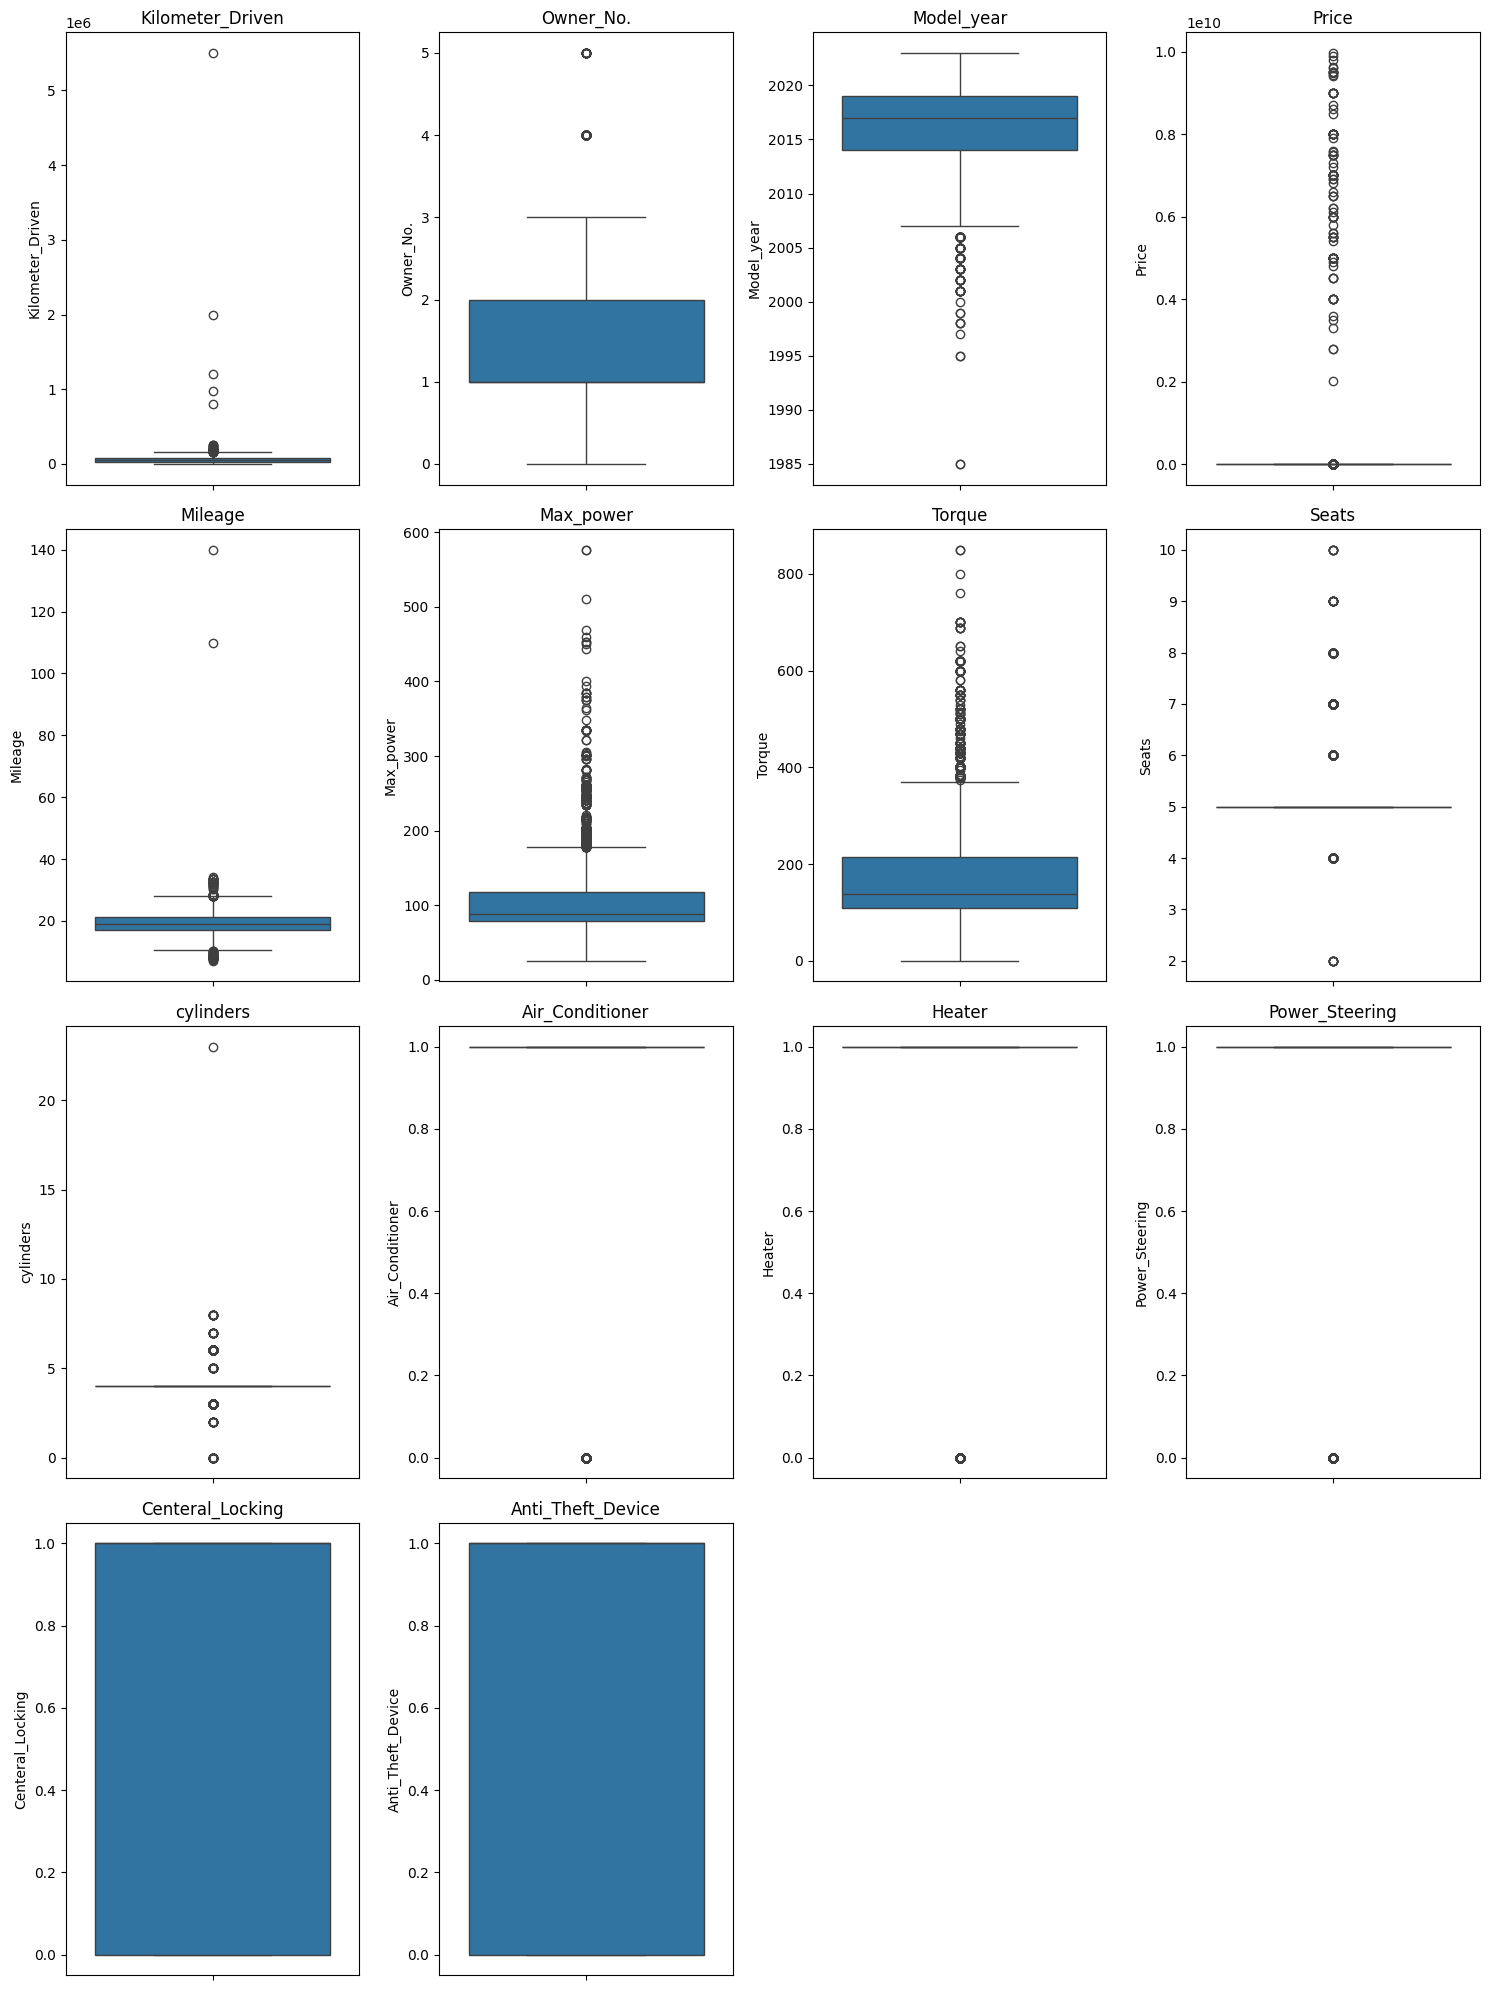

In [90]:
#seeing if outliers are present
def plot_boxplots(new_data, columns):
    num_cols = len(columns)
    num_rows = int(np.ceil(num_cols / 4))  # Adjust number of rows based on number of columns
    num_cols_subplot = min(num_cols, 4)  # Ensure at most 4 columns per row
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on number of rows

    for i, column in enumerate(columns):
        plt.subplot(num_rows, num_cols_subplot, i + 1)  # Adjust subplot grid
        sns.boxplot(new_data[column])
        plt.title(column)

    plt.tight_layout()
    plt.show()

# Example usage
numerical_cols = new_data.select_dtypes(include=['float', 'int']).columns
plot_boxplots(new_data, numerical_cols)

Skipping box plot for Seats due to limited variance.
Skipping box plot for cylinders due to limited variance.
Skipping box plot for Air_Conditioner due to limited variance.
Skipping box plot for Heater due to limited variance.
Skipping box plot for Power_Steering due to limited variance.


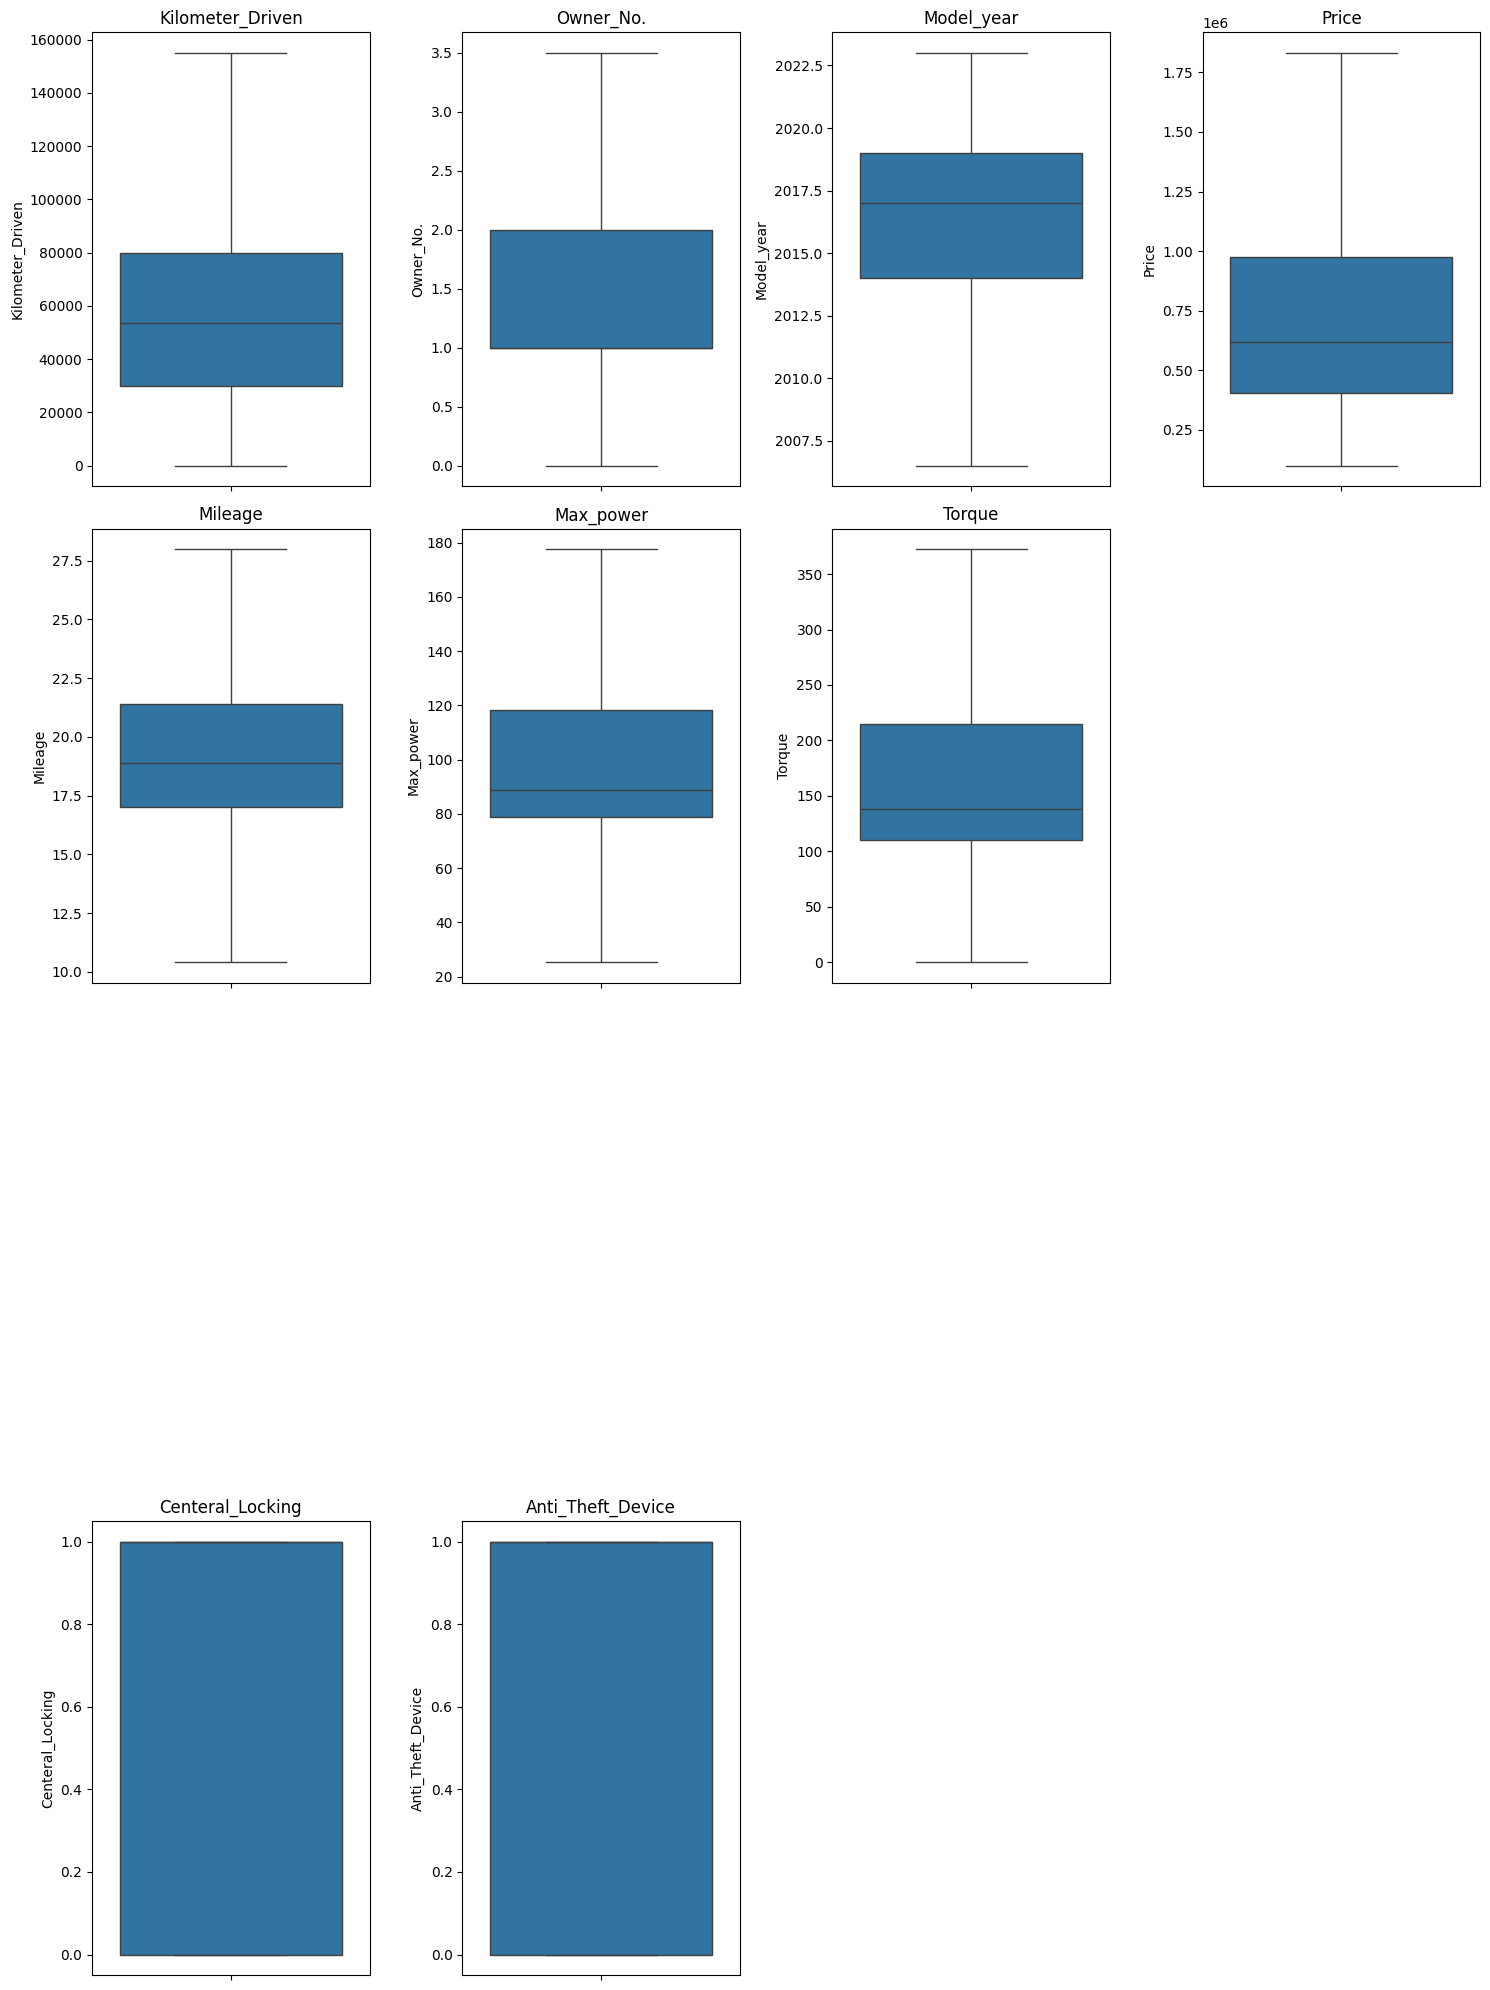

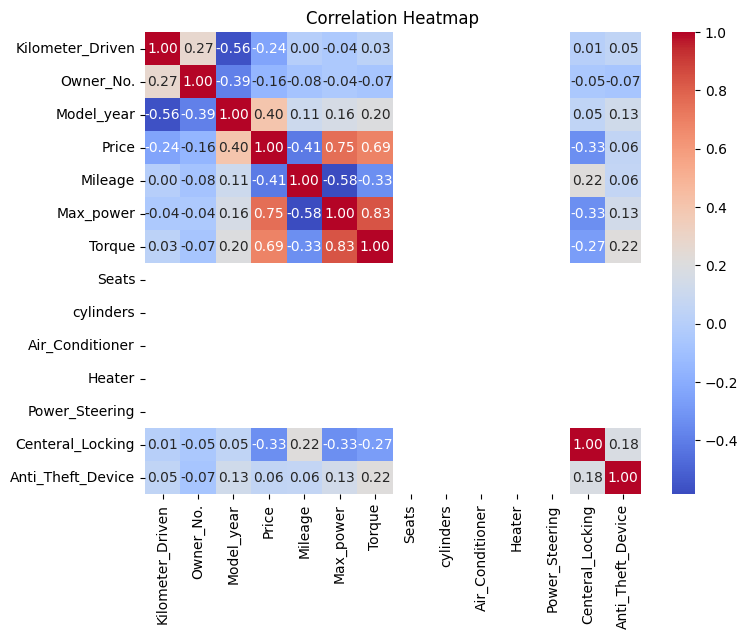

In [91]:
# Function to cap outliers using IQR
def cap_outliers_iqr(new_data, columns):
    for col in columns:
        Q1 = new_data[col].quantile(0.25)
        Q3 = new_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        new_data[col] = np.clip(new_data[col], lower_bound, upper_bound)
    return new_data

# Box plots to identify outliers
def plot_boxplots(new_data, columns):
    num_cols = len(columns)
    num_rows = int(np.ceil(num_cols / 4))  # Adjust number of rows based on number of columns
    num_cols_subplot = min(num_cols, 4)  # Ensure at most 4 columns per row
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on number of rows

    for i, column in enumerate(columns):
        if new_data[column].nunique() > 1:  # Skip columns with a single unique value
            plt.subplot(num_rows, num_cols_subplot, i + 1)  # Adjust subplot grid
            sns.boxplot(data=new_data[column])
            plt.title(column)
        else:
            print(f"Skipping box plot for {column} due to limited variance.")

    plt.tight_layout()
    plt.show()

# Correlation heatmap
def plot_correlation_heatmap_fix(new_data):
    # Select only numeric columns
    numeric_df = new_data.select_dtypes(include=['float64', 'int64'])

    # Remove columns with only NaN values after capping outliers
    numeric_df = numeric_df.dropna(axis=1, how='all')

    plt.figure(figsize=(8, 6))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

# Example usage
numeric_cols = new_data.select_dtypes(include=['float64', 'int64']).columns
# Filter columns with a single unique value or low variability
cols_to_plot = [col for col in numeric_cols if new_data[col].nunique() > 1 and new_data[col].std() > 0]
# Cap outliers before plotting
new_data = cap_outliers_iqr(new_data, cols_to_plot)
plot_boxplots(new_data, cols_to_plot)
plot_correlation_heatmap_fix(new_data[cols_to_plot])

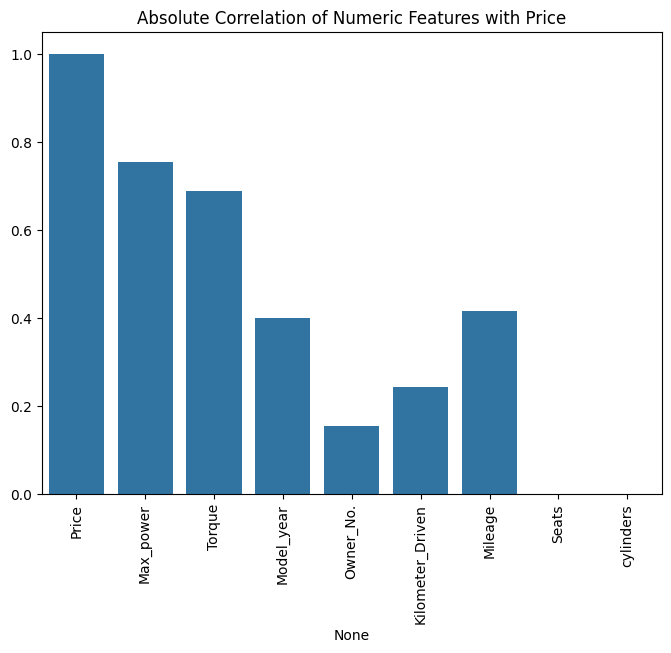

Features with high absolute correlation with Price:
 Price               1.000000
Max_power           0.754002
Torque              0.689153
Model_year          0.400361
Owner_No.           0.155322
Kilometer_Driven    0.242328
Mileage             0.414790
Seats                    NaN
cylinders                NaN
Name: Price, dtype: float64


In [92]:
# Correlation Analysis with the Target Variable Price
# Select only numeric columns for correlation calculation
numeric_cols = new_data.select_dtypes(include=['float64', 'int64']).columns
# Exclude specific columns
numeric_cols = [col for col in numeric_cols if col not in ['Air_Conditioner','Centeral_Locking' ,'Power_Steering','Heater','Anti_Theft_Device']]

# Calculate correlation of all numeric features with the target variable 'Price'
correlation_matrix = new_data[numeric_cols].corr()

# Extract correlation with 'Price'
correlation_with_price = correlation_matrix['Price'].sort_values(ascending=False)


# Convert correlation values to absolute for visualization
correlation_with_price_abs = np.abs(correlation_with_price)

# Plot the absolute correlation values
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_price_abs.index, y=correlation_with_price_abs.values)
plt.xticks(rotation=90)
plt.title('Absolute Correlation of Numeric Features with Price')
plt.show()

# Print features with high absolute correlation with Price
print("Features with high absolute correlation with Price:\n", correlation_with_price_abs)

In [93]:
new_data.to_csv('cleaned_cardata.csv', index=False)

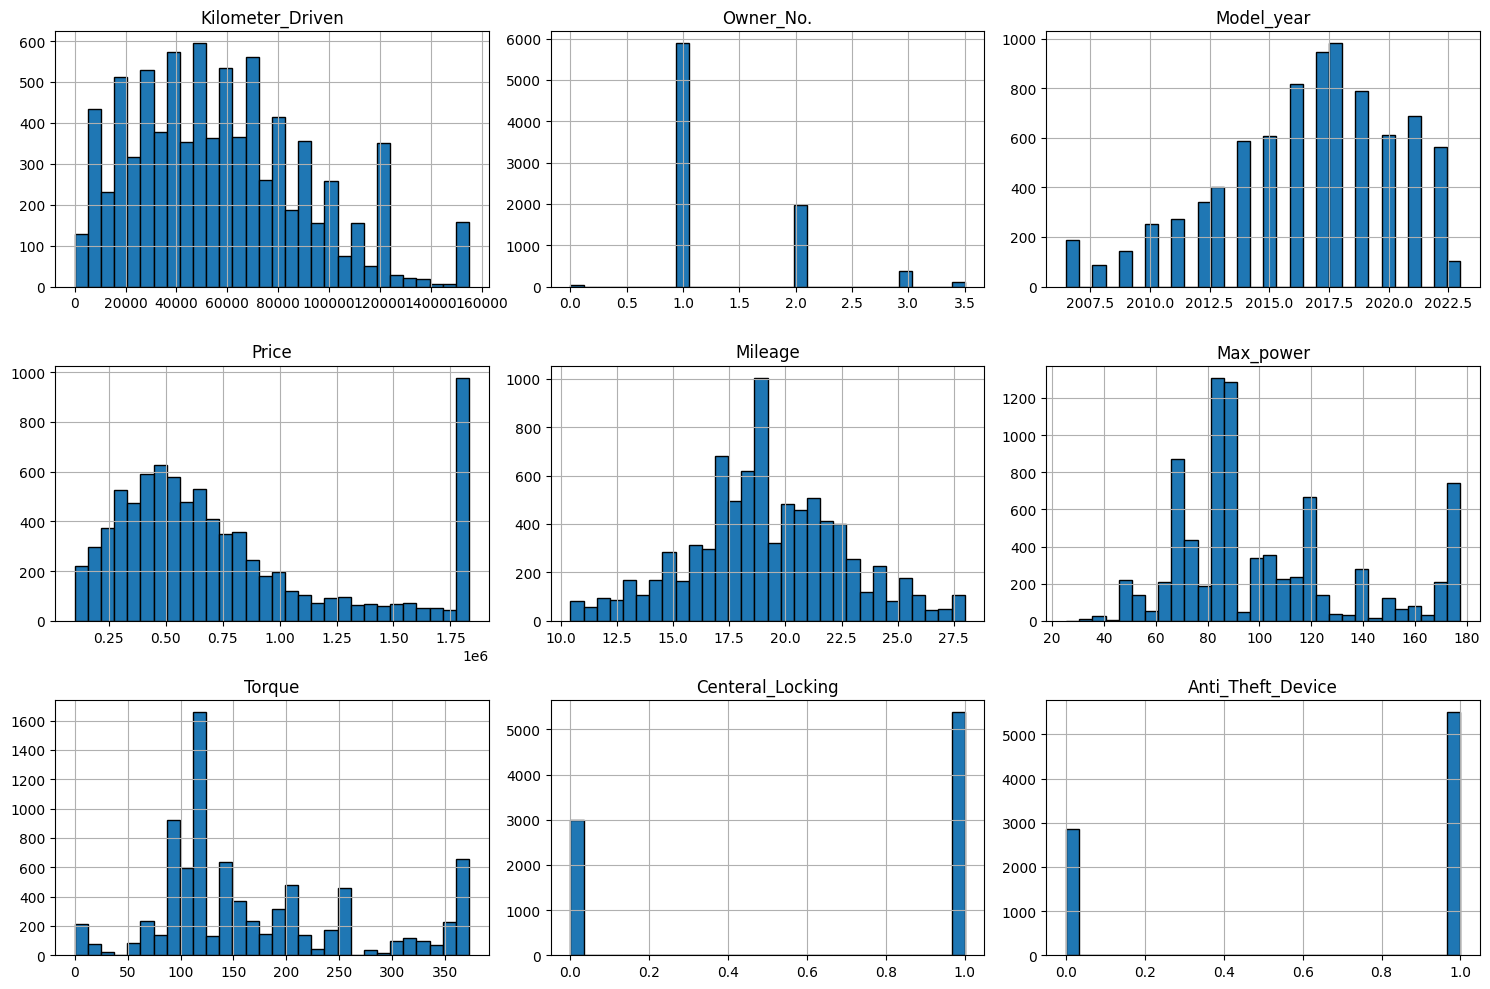

In [49]:
# Example usage
numeric_cols = new_data.select_dtypes(include=['float64', 'int64']).columns

# Filter columns with a single unique value or low variability
cols_to_plot = [col for col in numeric_cols if new_data[col].nunique() > 1 and new_data[col].std() > 0]

# Cap outliers before plotting
new_data = cap_outliers_iqr(new_data, cols_to_plot)


# Histogram for numerical features
def plot_histograms(new_data, columns):
    new_data[columns].hist(figsize=(15, 10), bins=30, edgecolor='black')
    plt.tight_layout()
    plt.show()
plot_histograms(new_data, cols_to_plot)

In [52]:
# Assuming 'new_data' contains your training data
col= ['Price']
scaler_2 = MinMaxScaler()

# Fit the scaler to your training data
scaler_2.fit(new_data[col])

# Transform the training data (optional, but usually done)
new_data[col] = scaler_2.transform(new_data[col])
new_data

,Fuel_type,Body_type,Kilometer_Driven,Transmission,Owner_No.,Original_equipment_manufacturer,Model,Model_year,Variant_name,Price,Mileage,Max_power,Torque,Seats,Engine_type,Engine_displacement,cylinders,Air_Conditioner,Heater,Power_Steering,Centeral_Locking,Anti_Theft_Device,City
0,Petrol,Hatchback,20000,Automatic,1.0,Volkswagen,Volkswagen Polo,2022.0,1.0 TSI Highline Plus AT,0.545192,16.47,108.62,175.0,5,1.0L TSI Petrol,999,4.0,1,1,1,1,1,Hyderabad
1,Petrol,Hatchback,85582,Manual,2.0,Hyundai,Hyundai EON,2014.0,Era Plus,0.092405,21.10,55.20,74.5,5,Petrol Engine,814,4.0,1,1,1,0,1,Hyderabad
2,Petrol,SUV,10000,Manual,1.0,Hyundai,Hyundai Venue,2023.0,S BSVI,0.493792,18.90,81.80,113.8,5,1.2 Kappa Petrol,1197,4.0,1,1,1,0,0,Hyderabad
3,Petrol,Hatchback,50750,Manual,1.0,Maruti,Maruti Baleno,2017.0,1.2 Alpha,0.329772,21.40,83.10,115.0,5,VVT Petrol Engine,1197,4.0,1,1,1,1,1,Hyderabad
4,Petrol,SUV,10000,Automatic,1.0,Mahindra,Mahindra Thar,2022.0,LX 4-Str Hard Top AT BSVI,1.000000,18.90,150.00,320.0,5,mStallion 150 TGDi Engine,1997,4.0,1,1,1,0,0,Hyderabad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Diesel,SUV,155000,Manual,2.0,Toyota,Toyota Fortuner,2012.0,4x4 MT,0.894600,12.55,168.50,343.0,5,D-4D Diesel Engine,2982,4.0,1,1,1,0,1,Bangalore
8365,Petrol,Sedan,56000,Manual,2.0,Maruti,Maruti SX4,2008.0,Zxi BSIII,0.132833,15.00,104.68,145.0,5,In-Line Engine,1586,4.0,1,1,1,0,0,Bangalore
8366,Petrol,Hatchback,42000,Manual,2.0,Honda,Honda Brio,2014.0,S MT,0.187699,19.40,86.80,109.0,5,i-VTEC Engine,1198,4.0,1,1,1,1,1,Bangalore
8367,Diesel,Hatchback,93003,Manual,1.0,Hyundai,Hyundai i20,2018.0,1.4 Asta Dual Tone,0.375397,22.54,88.73,219.7,5,U2 CRDI Diesel Engine,1396,4.0,1,1,1,1,1,Bangalore


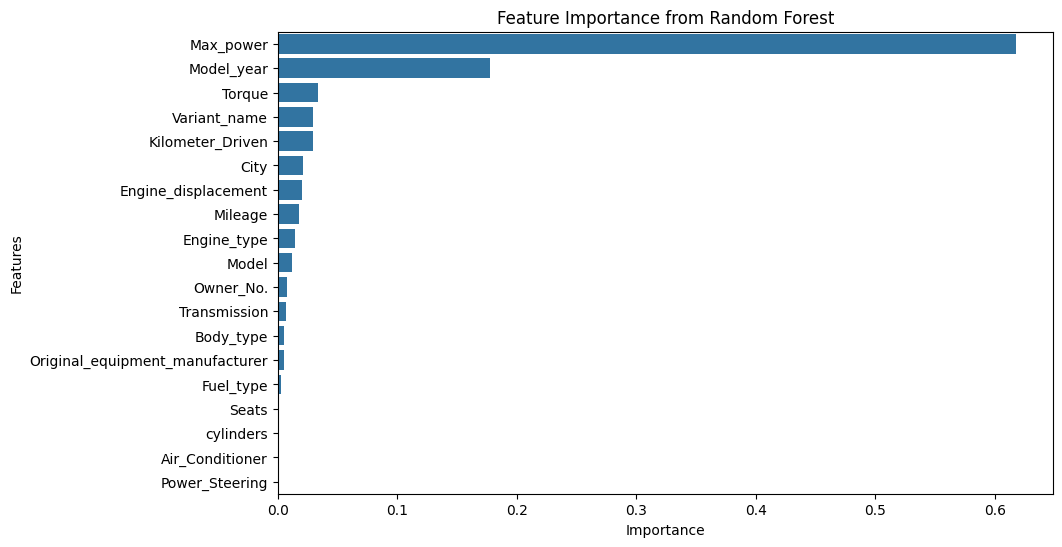

Top features based on importance:
 Max_power                          0.617427
Model_year                         0.177837
Torque                             0.033260
Variant_name                       0.029766
Kilometer_Driven                   0.029058
City                               0.021279
Engine_displacement                0.020077
Mileage                            0.017922
Engine_type                        0.014619
Model                              0.011656
Owner_No.                          0.008113
Transmission                       0.006905
Body_type                          0.004904
Original_equipment_manufacturer    0.004865
Fuel_type                          0.002312
Seats                              0.000000
cylinders                          0.000000
Air_Conditioner                    0.000000
Power_Steering                     0.000000
dtype: float64


In [53]:
# Feature Importance using Random Forest

# Preprocessing: Encoding categorical features (use LabelEncoder for simplicity)
categorical_columns = new_data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    new_data[col] = le.fit_transform(new_data[col].astype(str))
    label_encoders[col] = le

# Define features (X) and target (y)
X = new_data.drop(['Price','Heater' , 'Anti_Theft_Device','Centeral_Locking'], axis=1)  # Exclude specific columns
y = new_data['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Calculate feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Print the top features
print("Top features based on importance:\n", feature_importance)

In [54]:
selected_features=[ 'Mileage','Model_year','Kilometer_Driven','Engine_displacement', 'Fuel_type','Model',
    'Transmission', 'Owner_No.','Body_type','City','Max_power' ]
# Ensure the dataset contains only the selected features along with the target variable 'Price'
final_data = new_data[selected_features + ['Price']]

# Display the final dataframe to verify
final_data.head()

,Mileage,Model_year,Kilometer_Driven,Engine_displacement,Fuel_type,Model,Transmission,Owner_No.,Body_type,City,Max_power,Price
0,16.47,2022.0,20000,149,4,300,0,1.0,3,3,108.62,0.545192
1,21.10,2014.0,85582,143,4,74,1,2.0,3,3,55.20,0.092405
2,18.90,2023.0,10000,12,4,85,1,1.0,8,3,81.80,0.493792
3,21.40,2017.0,50750,12,4,157,1,1.0,3,3,83.10,0.329772
4,18.90,2022.0,10000,76,4,144,0,1.0,8,3,150.00,1.000000


In [55]:
#1. Train-Test Split
# Separate features (X) and target (y)
X = final_data.drop('Price', axis=1)
y = final_data['Price']

# Perform the train-test split (using 80-20 ratio here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression CV Mean MSE: 0.026997656709668028
Linear Regression - MSE: 0.028654497596065826, MAE: 0.09922974119963233, R²: 0.6670997477251028


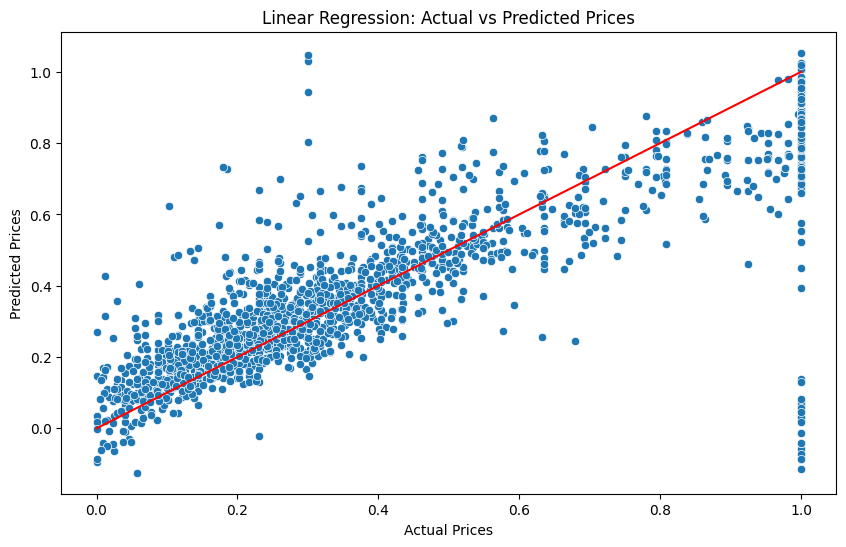

Best Ridge Alpha: {'alpha': 10}
Best Lasso Alpha: {'alpha': 0.01}


In [56]:
from sklearn.model_selection import cross_val_score, GridSearchCV
# Model Training
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Cross-Validation
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Linear Regression CV Mean MSE: {-cv_scores.mean()}')

# Model Prediction
y_pred_lr = lr_model.predict(X_test)

# Model Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'Linear Regression - MSE: {mse_lr}, MAE: {mae_lr}, R²: {r2_lr}')

# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_lr)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Linear Regression: Actual vs Predicted Prices')
plt.show()

# Hyperparameter Tuning for Ridge and Lasso using Grid Search
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_grid = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
print(f'Best Ridge Alpha: {ridge_grid.best_params_}')

lasso = Lasso()
lasso_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
lasso_grid = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
print(f'Best Lasso Alpha: {lasso_grid.best_params_}')

Gradient Boosting CV Mean MSE: 0.014425679868594854
Gradient Boosting - MSE: 0.014290614102170696, MAE: 0.06746679691098816, R²: 0.833975485913632


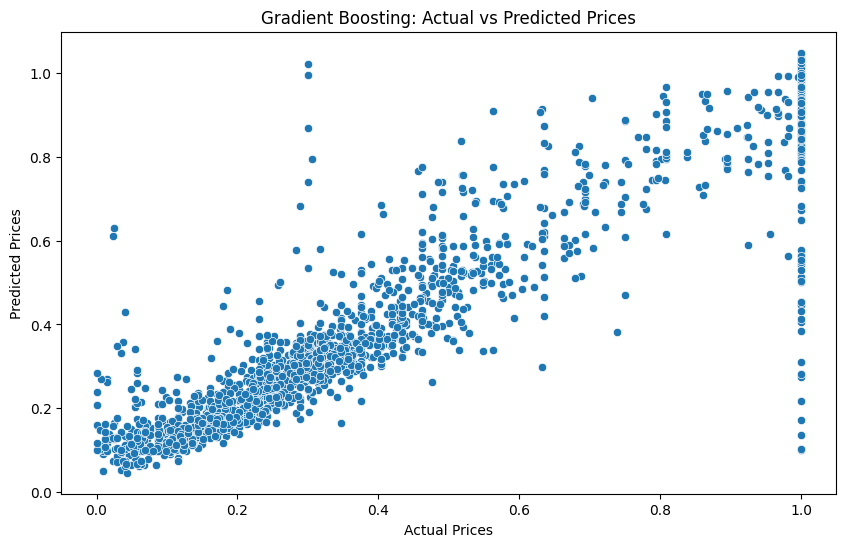

In [59]:
# Model Training
gbr_model = GradientBoostingRegressor(random_state=42)
gbr_model.fit(X_train, y_train)

# Cross-Validation
gbr_cv_scores = cross_val_score(gbr_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Gradient Boosting CV Mean MSE: {-gbr_cv_scores.mean()}')

# Model Prediction
y_pred_gbr = gbr_model.predict(X_test)

# Model Evaluation
mse_gbr = mean_squared_error(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
r2_gbr = r2_score(y_test, y_pred_gbr)

print(f'Gradient Boosting - MSE: {mse_gbr}, MAE: {mae_gbr}, R²: {r2_gbr}')

# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_gbr)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Gradient Boosting: Actual vs Predicted Prices')
plt.show()

Random Forest CV Mean MSE: 0.013330042329654726
Random Forest - MSE: 0.013280453790961879, MAE: 0.05912077917624752, R²: 0.845711256932199


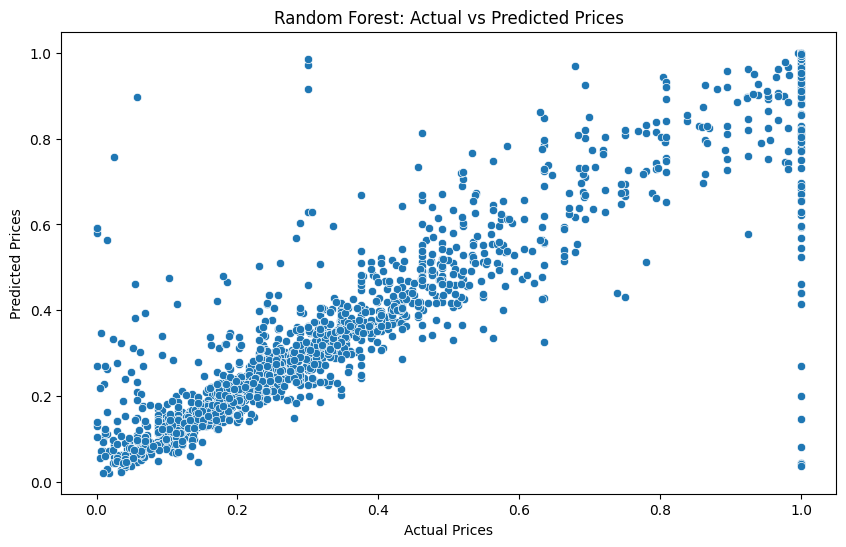

In [60]:
# Model Training with Bagging
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Cross-Validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'Random Forest CV Mean MSE: {-rf_cv_scores.mean()}')

# Model Prediction
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R²: {r2_rf}')

# Plotting Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest: Actual vs Predicted Prices')
plt.show()



In [63]:
best_model = rf_model

# Save the best model to a file for future use
joblib.dump(best_model, 'best_random_forest_model1.pkl')
print("Random Forest model saved as 'best_model.pkl'")

Random Forest model saved as 'best_model.pkl'


In [64]:
import joblib
joblib.dump(label_encoders,'label_encoder.pkl')
joblib.dump(scaler_2,'min_max.pkl')

['min_max.pkl']

<ipython-input-65-5f2c1a57bfc1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.loc[:,'Car_Age'] = 2024 - final_data['Model_year']
<ipython-input-65-5f2c1a57bfc1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.loc[:,'Mileage_normalized'] = final_data['Mileage'] / final_data['Car_Age']


Random Forest CV Mean MSE: 0.013900236706839092
Random Forest - MSE: 0.013235493414787332, MAE: 0.060249299093729135, R²: 0.8462335944996506
Training Time: 81.05061197280884 seconds


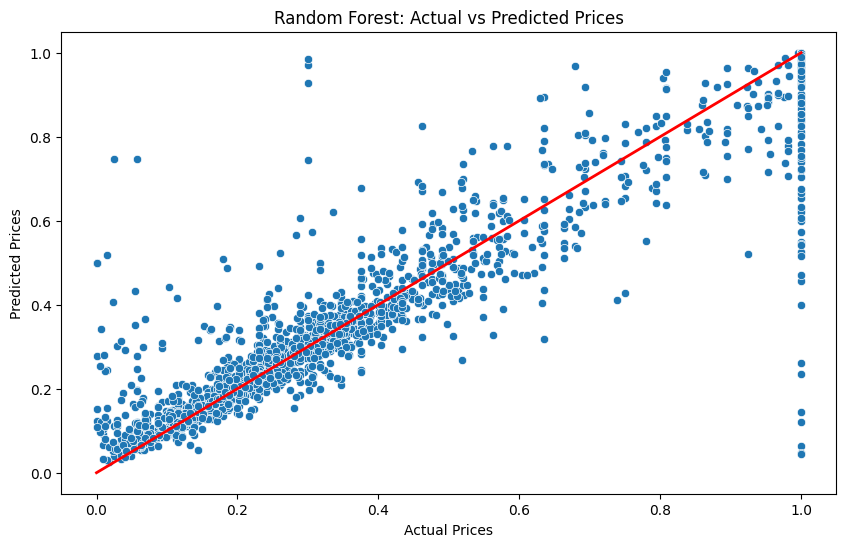

In [65]:
import time
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

# Create 'Car_Age' feature and normalize mileage
final_data.loc[:,'Car_Age'] = 2024 - final_data['Model_year']
final_data.loc[:,'Mileage_normalized'] = final_data['Mileage'] / final_data['Car_Age']

# Check if columns exist before dropping
columns_to_drop = ['Price','Seats']
existing_columns_to_drop = [col for col in columns_to_drop if col in final_data.columns]

# Prepare data for model training
X = final_data.drop(existing_columns_to_drop, axis=1)
y = final_data['Price']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model with RandomizedSearchCV
rf_model = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

start_time = time.time()
rf_random = RandomizedSearchCV(rf_model, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
end_time = time.time()

# Best model
final_model = rf_random.best_estimator_

# Cross-validation
rf_cv_scores = cross_val_score(final_model, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
print(f'Random Forest CV Mean MSE: {-rf_cv_scores.mean()}')

# Model prediction
y_pred_rf = final_model.predict(X_test)

# Model evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest - MSE: {mse_rf}, MAE: {mae_rf}, R²: {r2_rf}')
print(f'Training Time: {end_time - start_time} seconds')

# Plotting Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest: Actual vs Predicted Prices')
plt.show()

In [66]:
 # Save the final model to a file for future use
joblib.dump(final_model, 'final_random_forest_model1.pkl')
print("Best Random Forest model saved as 'final_random_forest_model.pkl'")

Best Random Forest model saved as 'final_random_forest_model.pkl'


In [67]:
from sklearn.linear_model import Ridge, Lasso

# Ridge (L2) Regularization
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
print(f"Ridge Regression MSE: {mean_squared_error(y_test, ridge_pred)}")

# Lasso (L1) Regularization
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print(f"Lasso Regression MSE: {mean_squared_error(y_test, lasso_pred)}")

Ridge Regression MSE: 0.0281699946167887
Lasso Regression MSE: 0.03097379567160113


In [68]:
# Define features and target
X = final_data.drop(['Price'], axis=1, errors='ignore')
y = final_data['Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"{name} MSE: {mse}")

Random Forest MSE: 0.013477039863898824
Ridge Regression MSE: 0.0253472195386494
Lasso Regression MSE: 0.028324440086940985
